# Training attempt 2: Thomson Lam 

## Summary: 

I am using 2014–2017 for Training/CV and 2018–2019 as my Final Test Set to prove the model's accuracy against known 2023/2024 rents. Once validated, I will use the 2020–2024 data to generate the actual 5-year forecasts for the city.

## Issues:
crime rate has low relevancy - currently just noise for XGB to overfit on: verify that crime rate data is relevant and joined correctly
missing 2016-2018 bedroom stats
missing 2022-2023 bedrooms stats

Strategy
do correlation matrix & ablation studies (SHAP), figure out what the model is overfitting on, or whether the data is just noisy.

```
1) inidividual yearly pipelines -> 2) pipelines to combine the yearly datasets into mastersheet
```
All individual pipelines require review & verification that the data is done correctly: 

```
1) is the whole year of data being used? 2) are the joins (data being joined together) correctly sourced (ie. crime data is not the same from 2024)?
```

Iterative: 
review data pipeline and diagnose the issue - 1) missing data, 2) data quality
review crime data & ensure quality of crime data
train grid search again

Considerations: 
if crime data is still bad, drop crime data
review missing data and data pipeline, and include them back into it
consider changing the target variable from 5 year lookup to just the next year
check training strategy and columns, ensure there is no data leakage across time; there should not be because the time split was done correctly
review master sheet variables and check whether the master sheet pipeline built the dataset correctly
review grid search: is regularization being applied correctly? Elasticnet or Lasso?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score 
from xgboost import XGBRegressor
import warnings
import shap
warnings.filterwarnings('ignore')

/Users/tlam/condo-cost-predictor/training/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
train_df.head()

Train shape: (790, 27)
Test shape: (316, 27)


,AREA_NAME,1_bedrooms_leased,2_bedrooms_avg_lease_rate,area_sq_meters,perimeter_meters,park_count,ASSAULT_RATE,AUTOTHEFT_RATE,ROBBERY_RATE,THEFTOVER_RATE,...,YEAR,avg_rent_1br,rent_lag_1,rent_lag_2,rent_growth_rate,TARGET_RENT_5YR,is_missing_THEFTOVER_RATE,is_missing_ROBBERY_RATE,is_missing_AUTOTHEFT_RATE,years_since_baseline
0,Agincourt North,135.0,1518.5,0.000813,0.134458,10.0,221.209717,56.127838,118.858955,3.301638,...,2014,1301.500000,1318.250000,1272.750000,-1.270624,1868.265625,0,0,0,0
1,Agincourt North,110.0,1547.5,0.000813,0.134458,10.0,257.275543,96.895988,123.625916,20.047445,...,2015,1342.250000,1301.500000,1318.250000,3.131003,1821.479821,0,0,0,1
2,Agincourt North,25.0,1749.0,0.000813,0.134458,10.0,274.091644,60.166462,50.138718,16.712906,...,2016,1492.166667,1342.250000,1301.500000,11.169057,1893.166667,0,0,0,2
3,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1492.166667,1342.250000,10.231207,1823.333333,0,0,0,3
4,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1644.833333,1492.166667,0.000000,1823.333333,0,0,0,3


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  790 non-null    object 
 1   1_bedrooms_leased          790 non-null    float64
 2   2_bedrooms_avg_lease_rate  790 non-null    float64
 3   area_sq_meters             790 non-null    float64
 4   perimeter_meters           790 non-null    float64
 5   park_count                 790 non-null    float64
 6   ASSAULT_RATE               790 non-null    float64
 7   AUTOTHEFT_RATE             790 non-null    float64
 8   ROBBERY_RATE               790 non-null    float64
 9   THEFTOVER_RATE             790 non-null    float64
 10  POPULATION                 790 non-null    float64
 11  total_stop_count           790 non-null    float64
 12  avg_stop_frequency         790 non-null    float64
 13  max_stop_frequency         790 non-null    float64

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  316 non-null    object 
 1   1_bedrooms_leased          316 non-null    float64
 2   2_bedrooms_avg_lease_rate  316 non-null    float64
 3   area_sq_meters             316 non-null    float64
 4   perimeter_meters           316 non-null    float64
 5   park_count                 316 non-null    float64
 6   ASSAULT_RATE               316 non-null    float64
 7   AUTOTHEFT_RATE             316 non-null    float64
 8   ROBBERY_RATE               316 non-null    float64
 9   THEFTOVER_RATE             316 non-null    float64
 10  POPULATION                 316 non-null    float64
 11  total_stop_count           316 non-null    float64
 12  avg_stop_frequency         316 non-null    float64
 13  max_stop_frequency         316 non-null    float64

In [ ]:
# train_df contains 2014-2017, test_df contains 2018-2019

In [5]:
train_df.info()
print(f"Unique years in train_df: {train_df['YEAR'].unique() if 'YEAR' in train_df.columns else 'YEAR COLUMN MISSING'}")
print(f"Total rows in train_df: {len(train_df)}")
print(f"Unique years in test_df: {test_df['YEAR'].unique() if 'YEAR' in test_df.columns else 'YEAR COLUMN MISSING'}")
print(f"Total rows in test_df: {len(test_df)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  790 non-null    object 
 1   1_bedrooms_leased          790 non-null    float64
 2   2_bedrooms_avg_lease_rate  790 non-null    float64
 3   area_sq_meters             790 non-null    float64
 4   perimeter_meters           790 non-null    float64
 5   park_count                 790 non-null    float64
 6   ASSAULT_RATE               790 non-null    float64
 7   AUTOTHEFT_RATE             790 non-null    float64
 8   ROBBERY_RATE               790 non-null    float64
 9   THEFTOVER_RATE             790 non-null    float64
 10  POPULATION                 790 non-null    float64
 11  total_stop_count           790 non-null    float64
 12  avg_stop_frequency         790 non-null    float64
 13  max_stop_frequency         790 non-null    float64

In [6]:
cols_to_drop = ['AREA_NAME', 'YEAR', 'TARGET_RENT_5YR']

# Create the final feature sets (X) and target sets (y). Training Set (2014-2017) -> Used for CV
y_train = train_df['TARGET_RENT_5YR']
X_train = train_df.drop(columns=cols_to_drop)

y_test = test_df['TARGET_RENT_5YR']
X_test = test_df.drop(columns=cols_to_drop)

In [7]:
X_train.columns

Index(['1_bedrooms_leased', '2_bedrooms_avg_lease_rate', 'area_sq_meters',
       'perimeter_meters', 'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE',
       'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION', 'total_stop_count',
       'avg_stop_frequency', 'max_stop_frequency', 'total_line_length_meters',
       'transit_line_density', 'distinct_route_count', 'avg_rent_1br',
       'rent_lag_1', 'rent_lag_2', 'rent_growth_rate',
       'is_missing_THEFTOVER_RATE', 'is_missing_ROBBERY_RATE',
       'is_missing_AUTOTHEFT_RATE', 'years_since_baseline'],
      dtype='object')

In [8]:
X_test.columns

Index(['1_bedrooms_leased', '2_bedrooms_avg_lease_rate', 'area_sq_meters',
       'perimeter_meters', 'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE',
       'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION', 'total_stop_count',
       'avg_stop_frequency', 'max_stop_frequency', 'total_line_length_meters',
       'transit_line_density', 'distinct_route_count', 'avg_rent_1br',
       'rent_lag_1', 'rent_lag_2', 'rent_growth_rate',
       'is_missing_THEFTOVER_RATE', 'is_missing_ROBBERY_RATE',
       'is_missing_AUTOTHEFT_RATE', 'years_since_baseline'],
      dtype='object')

In [9]:
y_train.head()

0    1868.265625
1    1821.479821
2    1893.166667
3    1823.333333
4    1823.333333
Name: TARGET_RENT_5YR, dtype: float64

In [10]:
y_test.head()

0    2464.500000
1    2220.000000
2    2464.500000
3    2220.000000
4    3092.166667
Name: TARGET_RENT_5YR, dtype: float64

In [11]:
# baseline model 
xgb_model = XGBRegressor(
    random_state=42,
    eval_metric='mae',
    n_estimators=500,       
    learning_rate=0.01,     
    max_depth=3,            
    objective='reg:absoluteerror', 
    
    # SGB for stopping memorization 
    subsample=0.7,
    colsample_bytree=0.7,
    
    # ElasticNet Regularization (TODO: Adjust these numbers to tune)
    alpha=1.0,             
    reg_lambda=1.0          
)

# Baseline training (no hyperparameter tuning)
xgb_model.fit(X_train, y_train.to_numpy())

# Baseline predictions
y_pred_baseline = xgb_model.predict(X_test)

# Regression metrics
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline Test MAE: ${baseline_mae:.2f}")
print(f"Baseline Test RMSE: ${baseline_rmse:.2f}")
print(f"Baseline Test R² Score: {baseline_r2:.4f}")

Baseline Test MAE: $252.40
Baseline Test RMSE: $408.44
Baseline Test R² Score: 0.2542


# Interpretations from MAE & RMSE of baseline model:

- MAE of `$` 260.94: on average, there is an error of ~$260, give or take
- When the model makes large mistakes on certain neighborhoods sometimes (~56% margin of error sometimes)
- model captures low variance of the data given R^2 of 0.25 

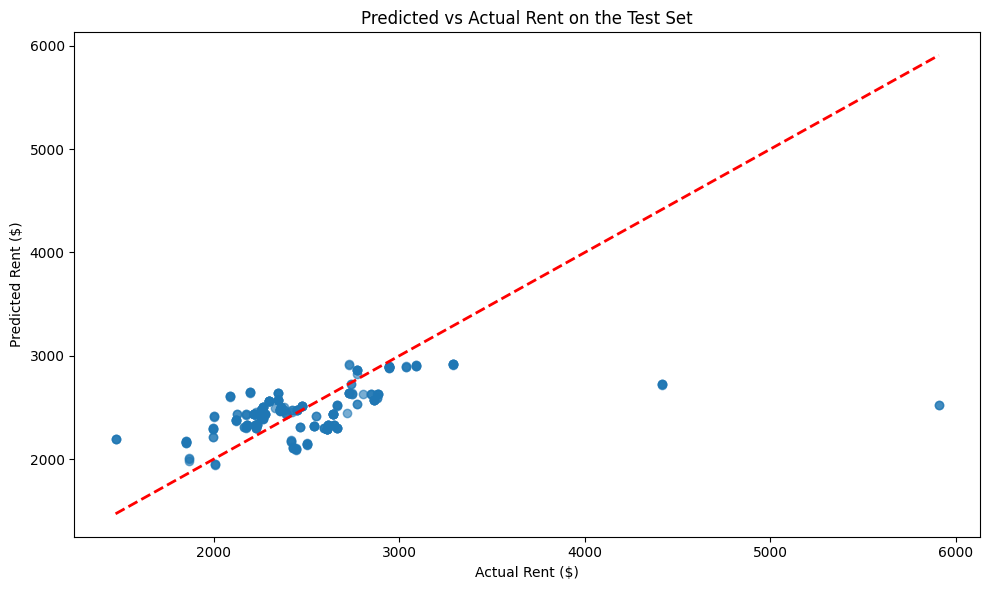

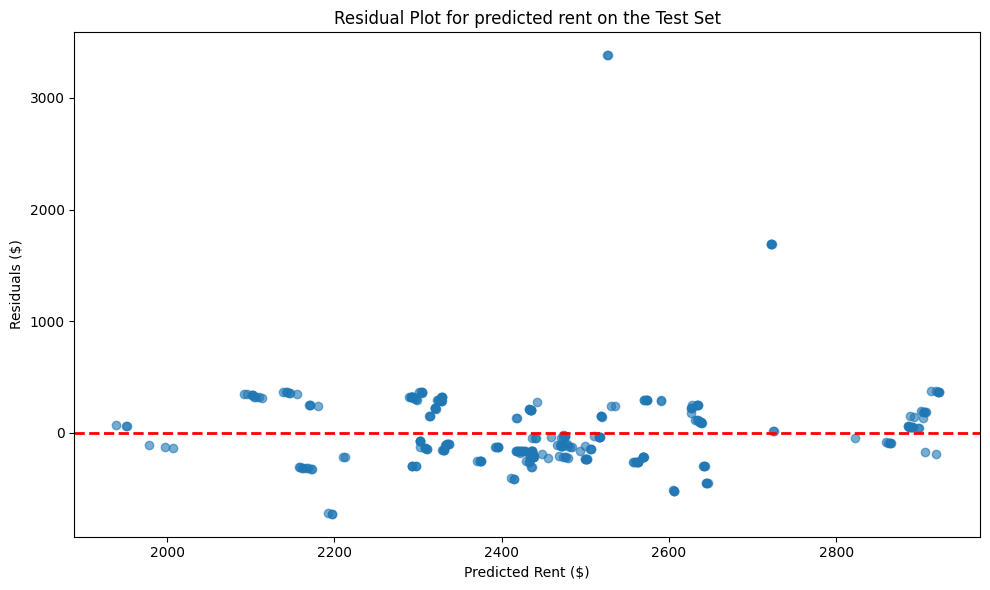

In [12]:
# Prediction vs Actual Plot for TEST set

y_pred_test = xgb_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rent ($)')
plt.ylabel('Predicted Rent ($)')
plt.title('Predicted vs Actual Rent on the Test Set')
plt.tight_layout()
plt.show()

# Residual Plot for TEST set
residuals_test = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals_test, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Rent ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot for predicted rent on the Test Set')
plt.tight_layout()
plt.show()

Baseline Train MAE: $70.44
Baseline Train RMSE: $118.03
Baseline Train R² Score: 0.8748


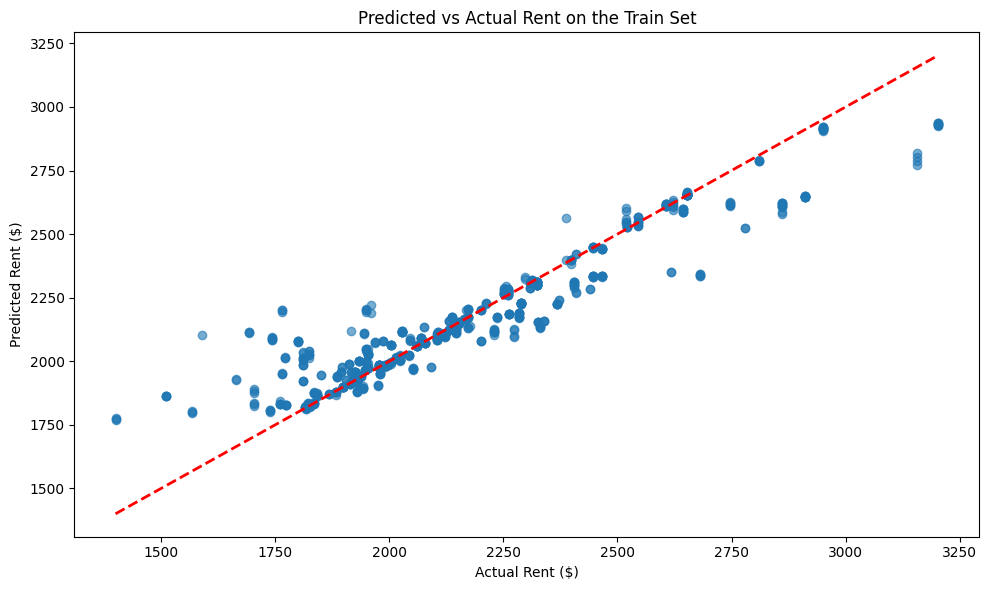

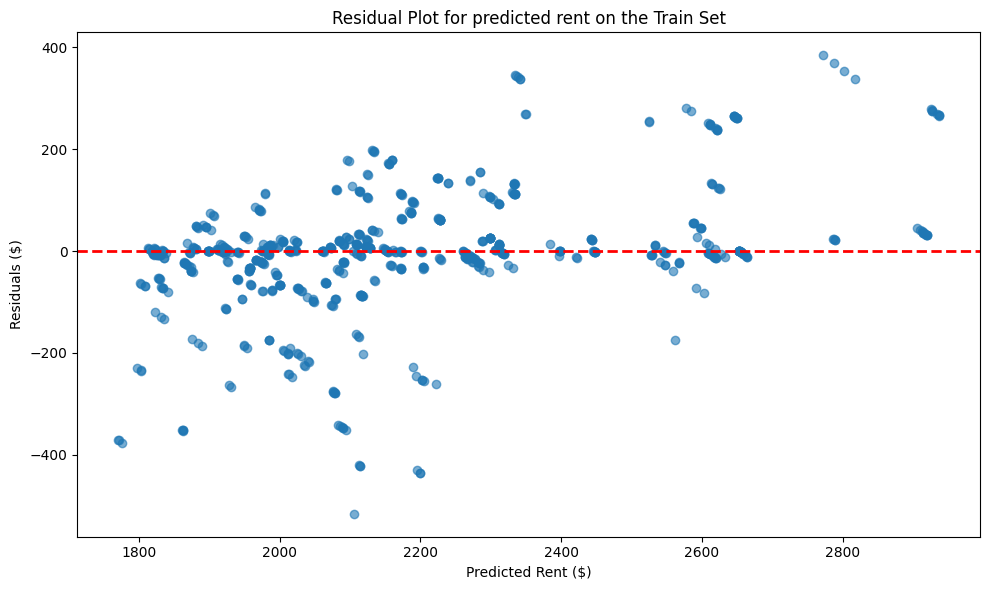

In [13]:
# Generate predictions for TRAIN set
y_pred_train = xgb_model.predict(X_train)

# Calculate train metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)

print(f"Baseline Train MAE: ${train_mae:.2f}")
print(f"Baseline Train RMSE: ${train_rmse:.2f}")
print(f"Baseline Train R² Score: {train_r2:.4f}")

# Prediction vs Actual Plot for TRAIN set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Rent ($)')
plt.ylabel('Predicted Rent ($)')
plt.title('Predicted vs Actual Rent on the Train Set')
plt.tight_layout()
plt.show()

# Residual Plot for TRAIN set
residuals_train = y_train - y_pred_train
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train, residuals_train, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Rent ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot for predicted rent on the Train Set')
plt.tight_layout()
plt.show()

In [14]:
# use time series split to ensure fits are trained on past and never future data to prevent leakage.
tscv = TimeSeriesSplit(n_splits=3)

# "Anti-Overfit" Grid
param_grid = {
    # FORCE Simplicity: No depth greater than 3
    'max_depth': [2, 3],  
    
    # FORCE Grouping: Require at least 10-15 "weighted" samples to make a split
    # This prevents the model from isolating a single weird neighborhood.
    'min_child_weight': [10, 15, 20], 
    
    # FORCE Regularization: Start high. 1.0 was too weak.
    'alpha': [10, 50, 100], 
    'reg_lambda': [10, 50, 100],
    
    # KEEP Randomness: This is working well
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.5, 0.6],
    
    # LOWER Learning Rate: Force it to learn slower with more trees
    'learning_rate': [0.01, 0.005],
    'n_estimators': [700, 1000] 
}

# Initialize GridSearchCV with XGBRegressor
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, eval_metric='mae'),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',  # negative MAE for easier interpretation/scale for $$$ 😛
    verbose=1,
    n_jobs=-1
)

print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train) # do CV and fit on training set 

print("\nBest Parameters:")
print(grid_search.best_params_)
best_mae = abs(grid_search.best_score_) # abs for removing negative 
print(f"best model has average error: ${best_mae:.2f}")

Starting GridSearchCV...
Fitting 3 folds for each of 864 candidates, totalling 2592 fits

Best Parameters:
{'alpha': 10, 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 1000, 'reg_lambda': 10, 'subsample': 0.7}
best model has average error: $90.98


In [20]:
# Get best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Predictions on test set
y_pred = best_xgb_model.predict(X_test)

# Calculate regression metrics
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)


print(f"\nImprovement over baseline:")
print(f"  MAE: ${baseline_mae - test_mae:.2f} (lower is better)")
print(f"  RMSE: ${baseline_rmse - test_rmse:.2f} (lower is better)")
print(f"  R²: {test_r2 - baseline_r2:.4f} (higher is better)")


Improvement over baseline:
  MAE: $-3.40 (lower is better)
  RMSE: $5.46 (lower is better)
  R²: 0.0198 (higher is better)


Grid Test MAE: $255.80
Grid Test RMSE: $402.98
Grid Test R² Score: 0.2740


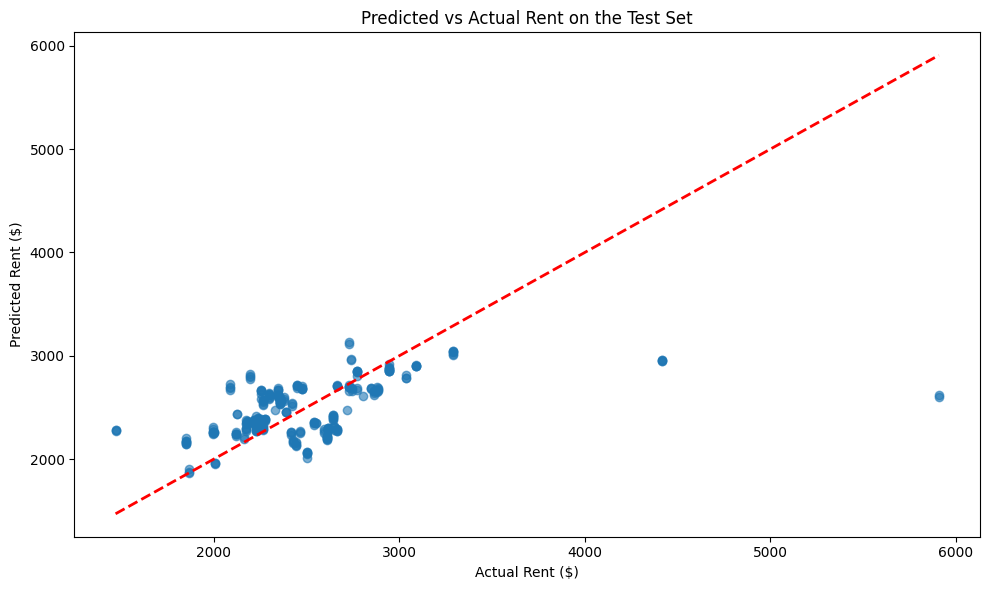

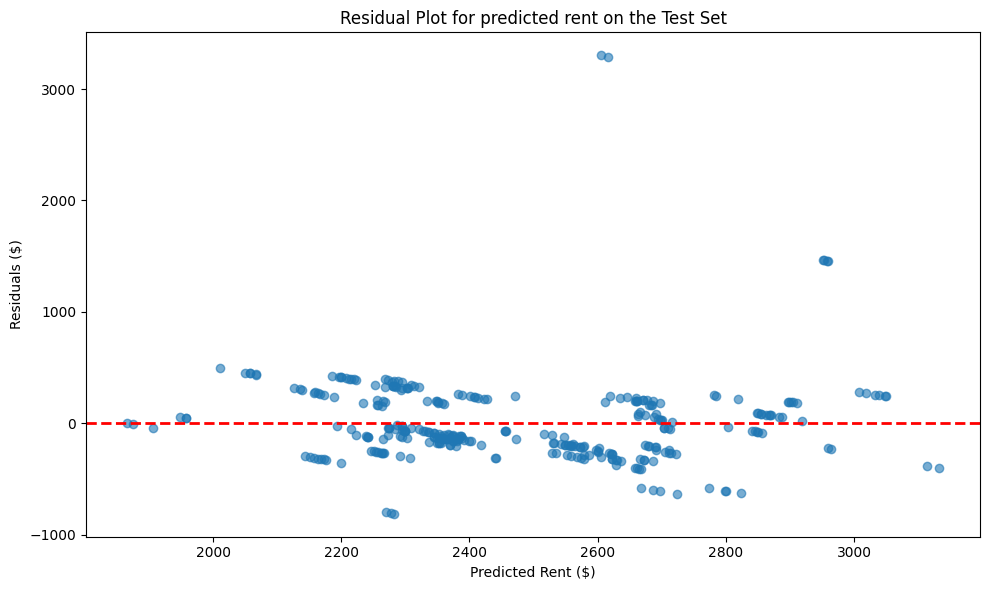

In [19]:
print(f"Grid Test MAE: ${test_mae:.2f}")
print(f"Grid Test RMSE: ${test_rmse:.2f}")
print(f"Grid Test R² Score: {test_r2:.4f}")

# Prediction vs Actual Plot for TEST set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rent ($)')
plt.ylabel('Predicted Rent ($)')
plt.title('Predicted vs Actual Rent on the Test Set')
plt.tight_layout()
plt.show()

# Residual Plot for TEST set
residuals_test = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals_test, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Rent ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot for predicted rent on the Test Set')
plt.tight_layout()
plt.show()

Train MAE: $49.64
Train RMSE: $68.34
Train R² Score: 0.9580


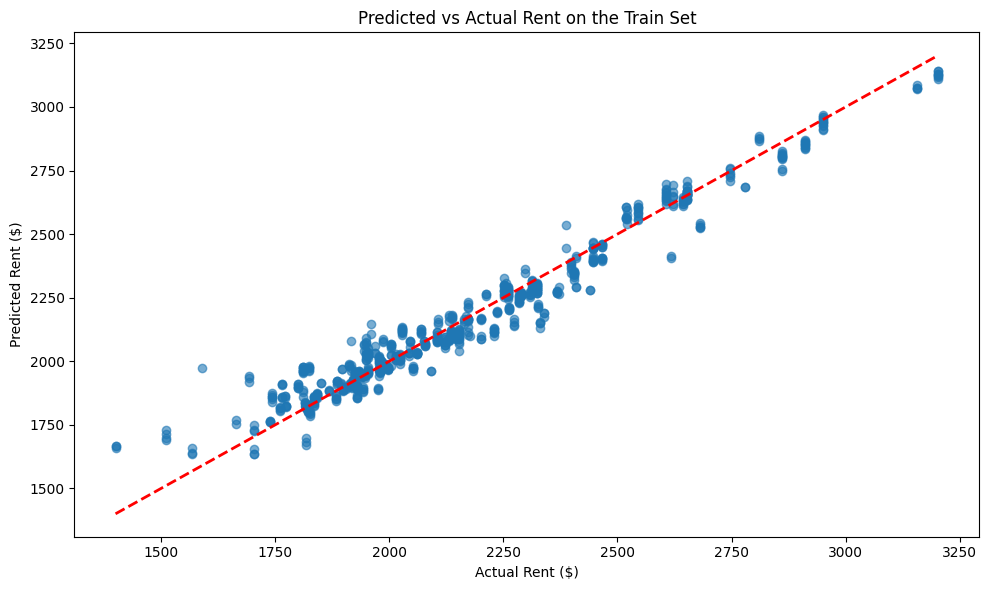

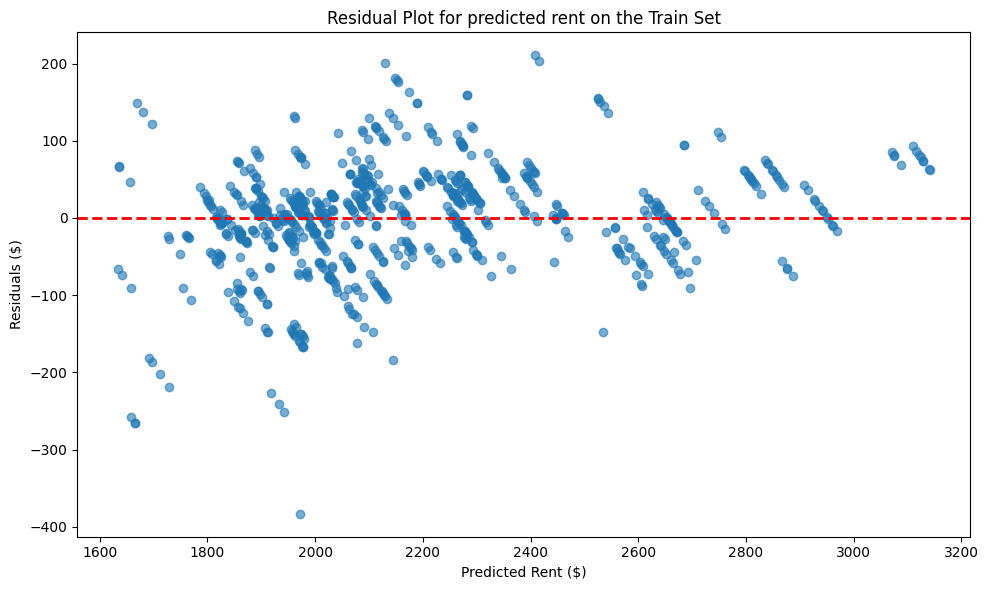

In [16]:
# Generate predictions for TRAIN set
y_pred_train = best_xgb_model.predict(X_train)

# Calculate train metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)

print(f"Grid Train MAE: ${train_mae:.2f}")
print(f"Grid Train RMSE: ${train_rmse:.2f}")
print(f"Grid Train R² Score: {train_r2:.4f}")

# Prediction vs Actual Plot for TRAIN set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Rent ($)')
plt.ylabel('Predicted Rent ($)')
plt.title('Predicted vs Actual Rent on the Train Set')
plt.tight_layout()
plt.show()

# Residual Plot for TRAIN set
residuals_train = y_train - y_pred_train
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train, residuals_train, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Rent ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot for predicted rent on the Train Set')
plt.tight_layout()
plt.show()

# Findings 

- The model is underperforming compared to the baseline when evaluated on the test set (2018-2019), likely struggling to find any real meaningful features ($15.5 worse than simple baseline, RMSE is higher than MAE, likely making big mistakes on some neighborhoods), and only 21% of the data is meaningful to the model.

# Suggestions/Next steps 

1. Ablation studies: examine SHAP and see whether overfitting occurs
2. Plot R^2 score to neighborhoods, and check which neighborhoods are causing the issue
3. Change of target variable: the 5 year look ahead likely isn't very applicable because rent dynamics fluctuate heavily per year
4. Hyperparam overfitting: the fact that running grid search gave worse results than a simple baseline suggests that grid search itself might be overfitting to noise; restricting max depth to 3 might give better results
5. Experiment with Optuna and see whether Bayesian optimization helps 
6. Create a rent_vs_city_avg feature
7. Add a feature for avergage rent of the adjacent neighborhoods or the rent of other neighborhoods to smooth out the noise by looking at what neighbors are doing
8. log transforming the target variable then testing that
9. Plot residual vs population density 


Experimentation for 4: Try depth of only 9 and depth of only 3, then compare it to the baseline. Then increase the depth further and see whether performance drops from there, and try running with only 3,5, and 7.  

"Experiment with max_depth (3, 4, 5) in conjunction with lambda (L2 regularization) and alpha (L1 regularization). This forces XGBoost to be 'conservative' and ignore the high-frequency noise in the crime and population features."

## Other solutions

If the solutions do not work, then revisiting the data pipeline is needed to get more data or diagnose missing data problem, or verify outlier handling and data cleaning is done correctly. 

# Summary 

21% R^2 is very reasonable, and shows that there is no data leakage in the actual training code here. 

## SHAP Interpretation Guide

### What to look for:

1. **Summary Plot (Beeswarm)**:
   - Red points = high feature values, Blue points = low feature values
   - X-axis shows SHAP value (impact on prediction)
   - Features are ordered by importance (top to bottom)
   - Look for features that consistently push predictions in one direction

2. **Feature Importance (Bar)**:
   - Shows mean absolute SHAP value for each feature
   - Compare with XGBoost's built-in feature importance
   - Discrepancies may indicate overfitting or interaction effects

3. **Dependence Plots**:
   - X-axis: feature value, Y-axis: SHAP value (impact on prediction)
   - Color indicates interaction with another feature
   - Look for linear/non-linear relationships
   - Scattered patterns may indicate noise or overfitting

4. **Waterfall Plots**:
   - Shows how each feature contributes to a single prediction
   - Starts from base value (average prediction)
   - Each bar shows feature contribution
   - Useful for debugging specific predictions

5. **Variance Analysis**:
   - High variance + low importance = potential noise/overfitting
   - Crime features should be checked here based on notes
   - Consider dropping features with high variance-to-importance ratio

In [21]:
# FIX: shap_importance was used before being defined, causing NameError.
# Solution: Calculate shap_importance at the beginning of this cell before using it.

explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)

# Calculate SHAP importance (mean absolute SHAP values)
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

# SHAP Analysis Summary - Identify potential issues


# 1. Check if crime features have low impact (as mentioned in notes)
crime_features = ['ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'THEFTOVER_RATE']
crime_shap_importance = shap_importance[shap_importance['feature'].isin(crime_features)]

print("Crime Feature SHAP Importance:")
print(crime_shap_importance.sort_values('mean_abs_shap', ascending=False))
print(f"\nMean |SHAP| for crime features: {crime_shap_importance['mean_abs_shap'].mean():.2f}")
print(f"Mean |SHAP| for all features: {shap_importance['mean_abs_shap'].mean():.2f}")



Crime Feature SHAP Importance:
          feature  mean_abs_shap
6  AUTOTHEFT_RATE       2.230060
7    ROBBERY_RATE       2.228660
8  THEFTOVER_RATE       1.627504
5    ASSAULT_RATE       0.843318

Mean |SHAP| for crime features: 1.73
Mean |SHAP| for all features: 19.60


In [22]:
# 2. Calculate feature contribution variance (high variance = inconsistent impact)
shap_variance = pd.DataFrame({
    'feature': X_test.columns,
    'shap_variance': np.var(shap_values.values, axis=0)
}).sort_values('shap_variance', ascending=False)

print("\n\nTop 10 Features by SHAP Variance (inconsistent impact):")
print(shap_variance.head(10))

# 3. Identify potential overfitting features (high variance but low mean importance)
shap_analysis = shap_importance.merge(shap_variance, on='feature')
shap_analysis['variance_to_importance_ratio'] = shap_analysis['shap_variance'] / (shap_analysis['mean_abs_shap'] + 1e-6)
shap_analysis = shap_analysis.sort_values('variance_to_importance_ratio', ascending=False)

print("\n\nPotential Overfitting Features (high variance, low importance):")
print(shap_analysis.head(10)[['feature', 'mean_abs_shap', 'shap_variance', 'variance_to_importance_ratio']])



Top 10 Features by SHAP Variance (inconsistent impact):
                      feature  shap_variance
16               avg_rent_1br   35009.461897
17                 rent_lag_1    7204.031010
19           rent_growth_rate    2018.820336
1   2_bedrooms_avg_lease_rate    1227.298706
0           1_bedrooms_leased    1050.016400
18                 rent_lag_2     301.499212
9                  POPULATION      65.469178
2              area_sq_meters      51.674113
3            perimeter_meters      46.049085
23       years_since_baseline      39.368309


Potential Overfitting Features (high variance, low importance):
                      feature  mean_abs_shap  shap_variance  \
0                avg_rent_1br     168.565764   35009.461897   
1                  rent_lag_1     102.418832    7204.031010   
4            rent_growth_rate      29.668117    2018.820336   
5           1_bedrooms_leased      23.852336    1050.016400   
6                  rent_lag_2      12.106886     301.499212   
2  

In [23]:
# SHAP Force Plot for multiple predictions
# Note: Force plots work best in Jupyter with shap.initjs()

shap.initjs()

# Force plot for first 10 test samples
shap.force_plot(
    explainer.expected_value, 
    shap_values.values[:10], 
    X_test.iloc[:10]
)

Best Prediction - Actual: $1868.33, Predicted: $1865.16, Error: $3.18
Worst Prediction - Actual: $5907.83, Predicted: $2604.52, Error: $3303.31


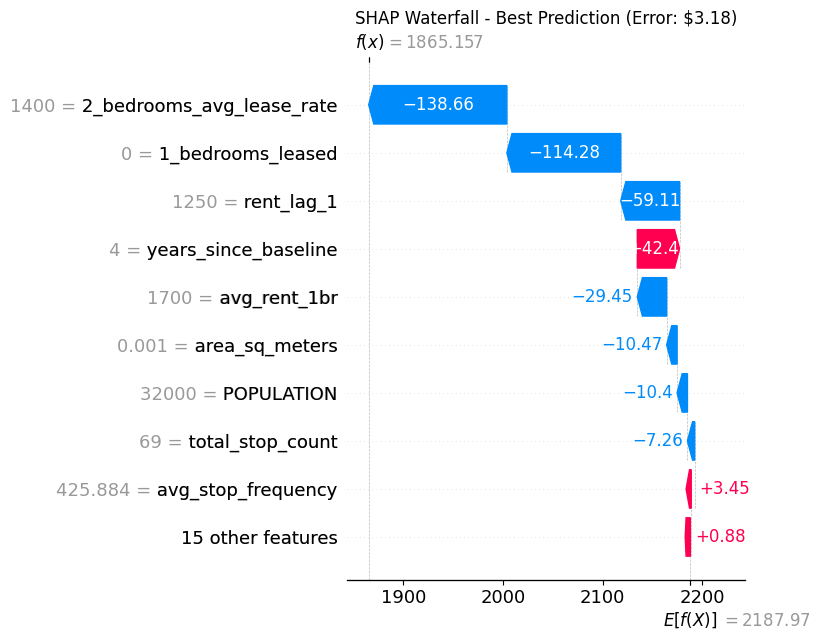

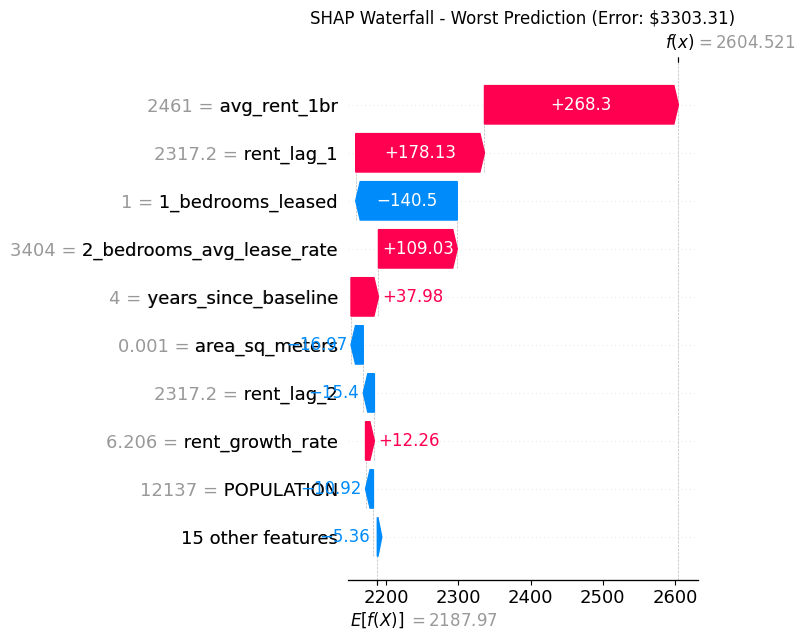

In [24]:
# SHAP Waterfall Plot - Explain individual predictions
# Show explanations for best and worst predictions

# Find best and worst predictions
prediction_errors = np.abs(y_test.values - y_pred)
best_pred_idx = np.argmin(prediction_errors)
worst_pred_idx = np.argmax(prediction_errors)

print(f"Best Prediction - Actual: ${y_test.iloc[best_pred_idx]:.2f}, Predicted: ${y_pred[best_pred_idx]:.2f}, Error: ${prediction_errors[best_pred_idx]:.2f}")
print(f"Worst Prediction - Actual: ${y_test.iloc[worst_pred_idx]:.2f}, Predicted: ${y_pred[worst_pred_idx]:.2f}, Error: ${prediction_errors[worst_pred_idx]:.2f}")

# Waterfall plot for best prediction
plt.figure(figsize=(10, 6))
shap.waterfall_plot(shap.Explanation(
    values=shap_values[best_pred_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[best_pred_idx],
    feature_names=X_test.columns.tolist()
), show=False)
plt.title(f'SHAP Waterfall - Best Prediction (Error: ${prediction_errors[best_pred_idx]:.2f})')
plt.tight_layout()
plt.show()

# Waterfall plot for worst prediction
plt.figure(figsize=(10, 6))
shap.waterfall_plot(shap.Explanation(
    values=shap_values[worst_pred_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[worst_pred_idx],
    feature_names=X_test.columns.tolist()
), show=False)
plt.title(f'SHAP Waterfall - Worst Prediction (Error: ${prediction_errors[worst_pred_idx]:.2f})')
plt.tight_layout()
plt.show()

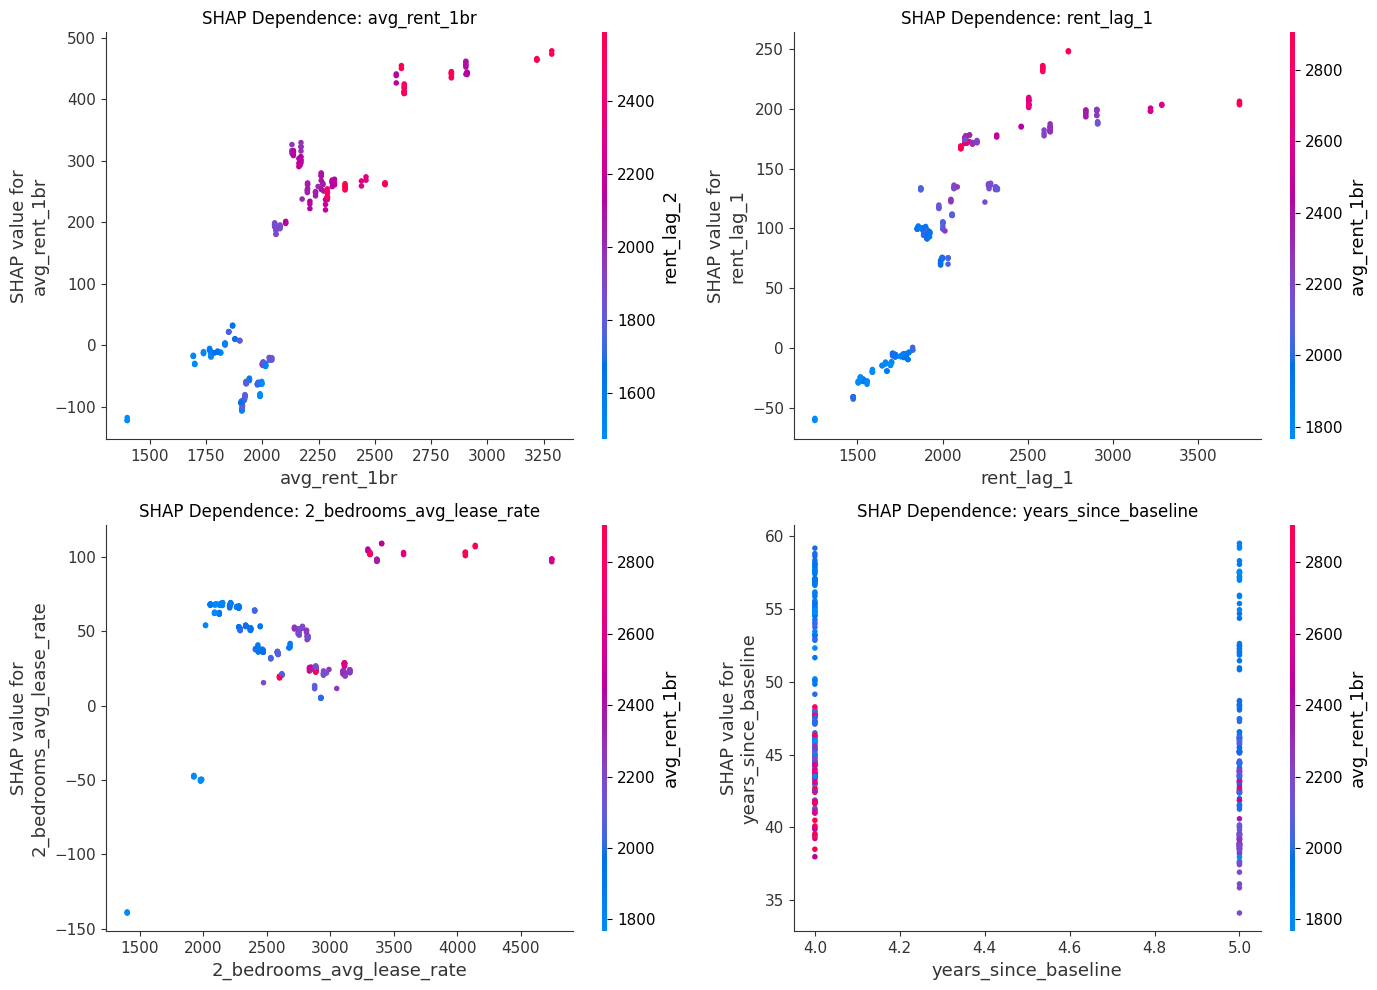

In [25]:
# SHAP Dependence Plots for top 4 features
# These show how feature values affect predictions and potential interactions

top_features = shap_importance.head(4)['feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature, 
        shap_values.values, 
        X_test, 
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'SHAP Dependence: {feature}')

plt.tight_layout()
plt.show()

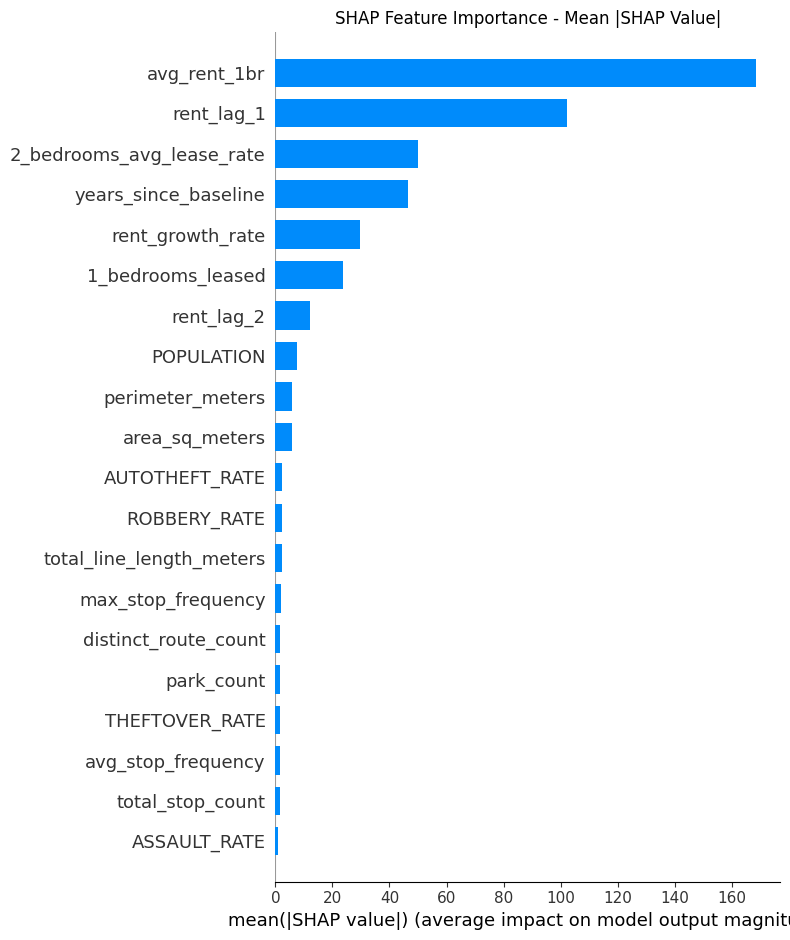


Top 10 Features by Mean |SHAP Value|:
                      feature  mean_abs_shap
16               avg_rent_1br     168.565764
17                 rent_lag_1     102.418832
1   2_bedrooms_avg_lease_rate      49.844610
23       years_since_baseline      46.654328
19           rent_growth_rate      29.668117
0           1_bedrooms_leased      23.852336
18                 rent_lag_2      12.106886
9                  POPULATION       7.599654
3            perimeter_meters       5.782611
2              area_sq_meters       5.774894


In [26]:
# SHAP Summary Plot (Bar) - Mean absolute SHAP values for feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values.values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Mean |SHAP Value|')
plt.tight_layout()
plt.show()

# Compare with XGBoost built-in feature importance
print("\nTop 10 Features by Mean |SHAP Value|:")
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)
print(shap_importance.head(10))

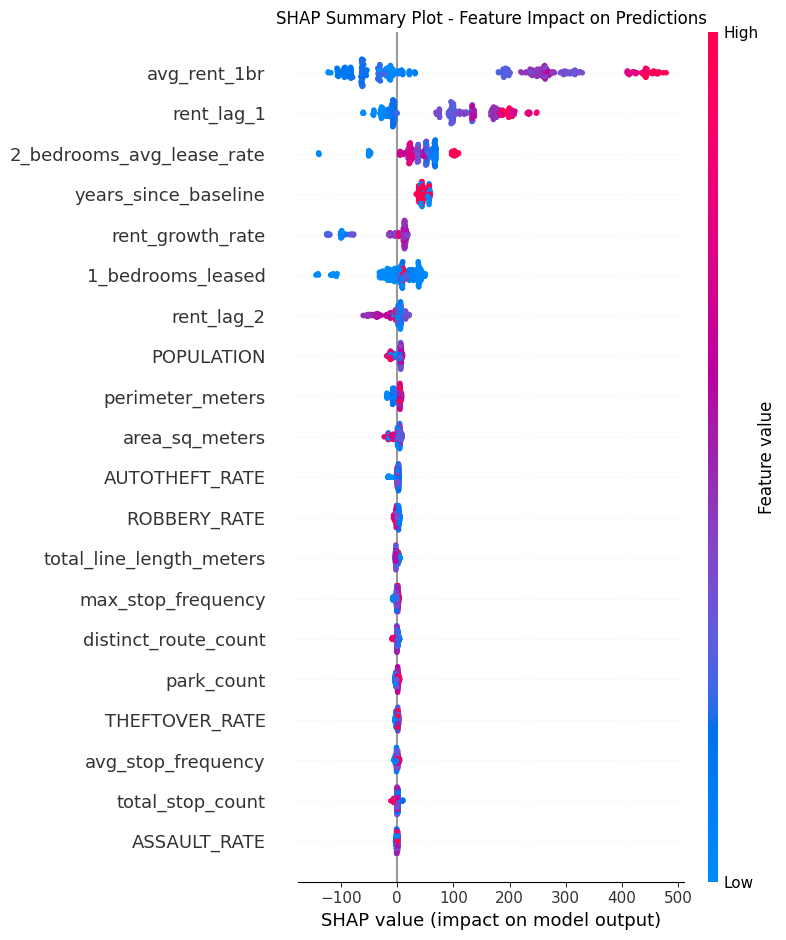

In [27]:
# SHAP Summary Plot (Beeswarm) - Shows feature importance and impact direction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Predictions')
plt.tight_layout()
plt.show()

# feature Importance Plot 

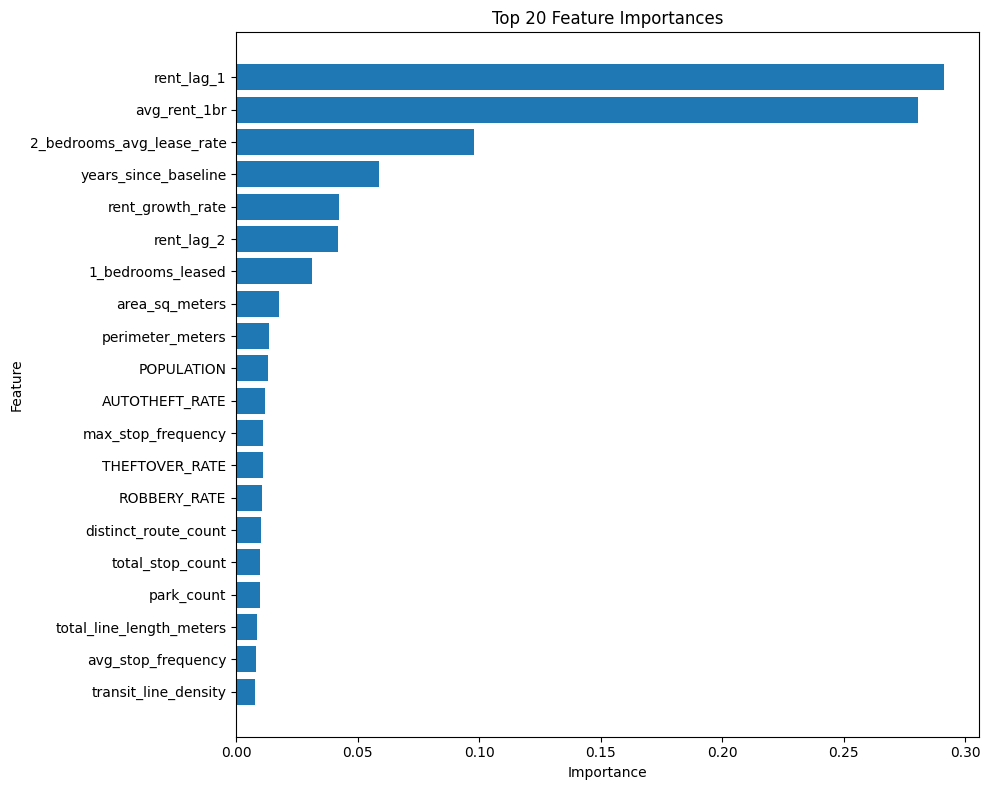


Top 10 Most Important Features:
                      feature  importance
17                 rent_lag_1    0.291117
16               avg_rent_1br    0.280549
1   2_bedrooms_avg_lease_rate    0.097992
23       years_since_baseline    0.058908
19           rent_growth_rate    0.042138
18                 rent_lag_2    0.041730
0           1_bedrooms_leased    0.031015
2              area_sq_meters    0.017781
3            perimeter_meters    0.013707
9                  POPULATION    0.013100


In [28]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Save the model for reference

In [29]:
# Save the trained model (optional)
import pickle

with open('models/xgb_model_3.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

print("Model saved as 'xgb_model_3.pkl'") # NOTE: make sure to change this per save, and document the changes.

Model saved as 'xgb_model_3.pkl'
